CFL 1.695


Operator `initdamp` ran in 0.03 s
Operator `Kernel` ran in 26.65 s


fd shot  0


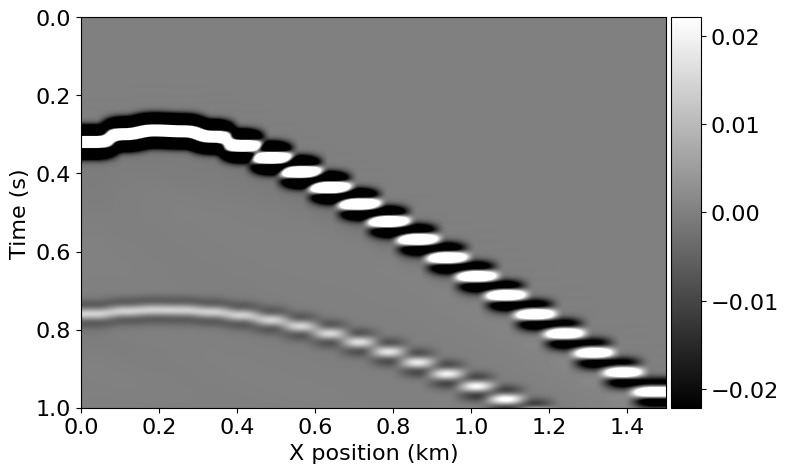

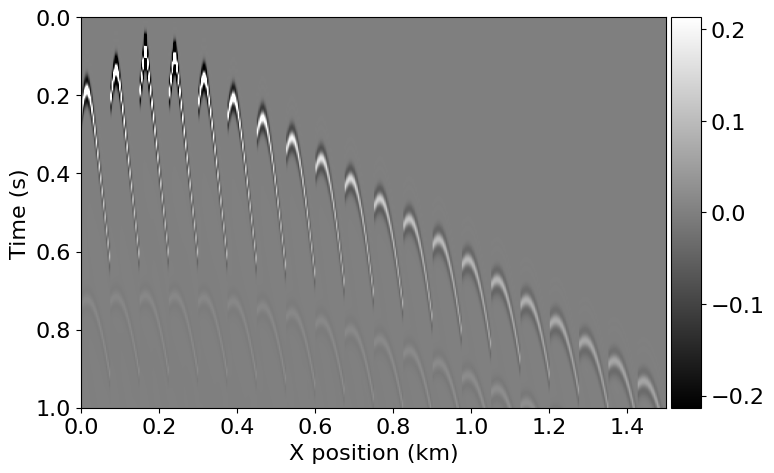

Operator `Kernel` ran in 25.73 s


fd shot  1


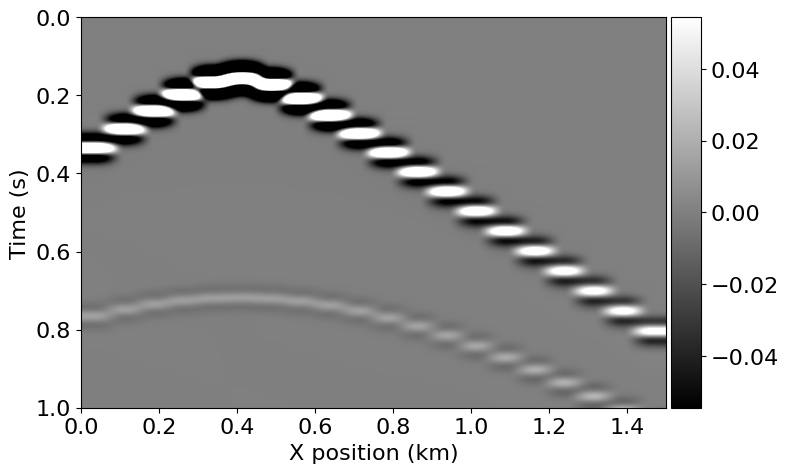

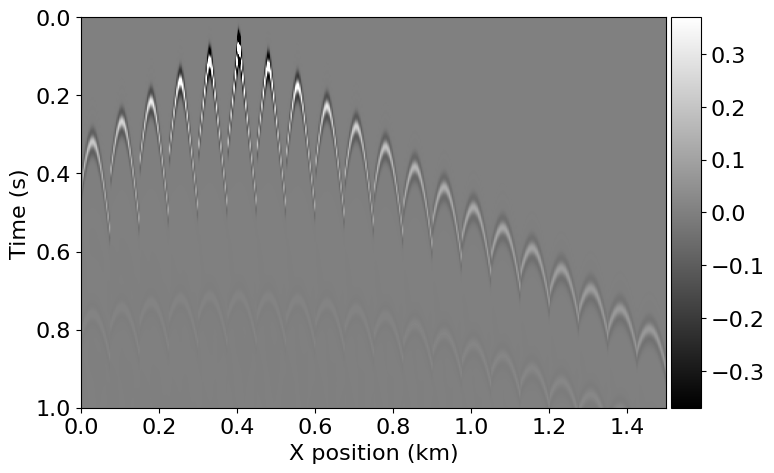

Operator `Kernel` ran in 25.68 s


fd shot  2


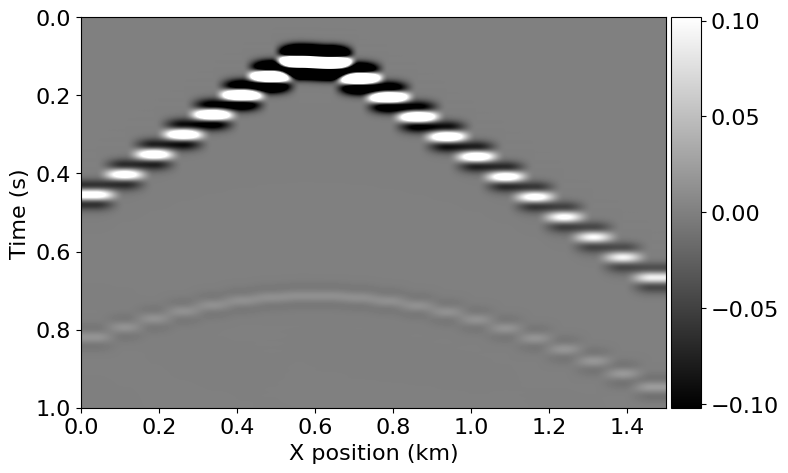

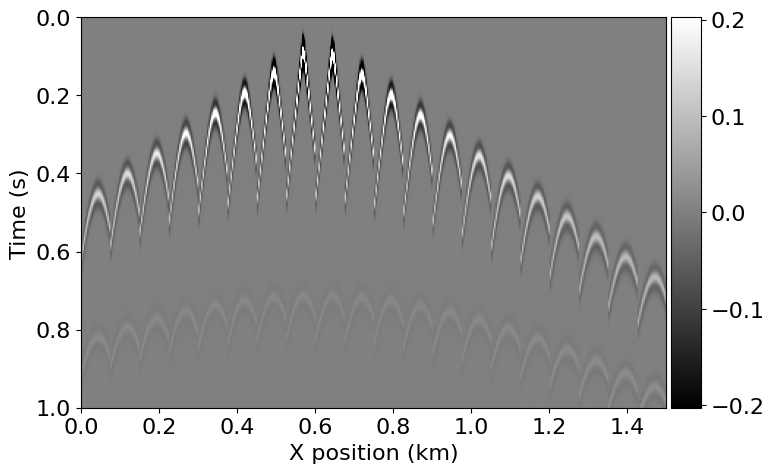

Operator `Kernel` ran in 25.74 s


fd shot  3


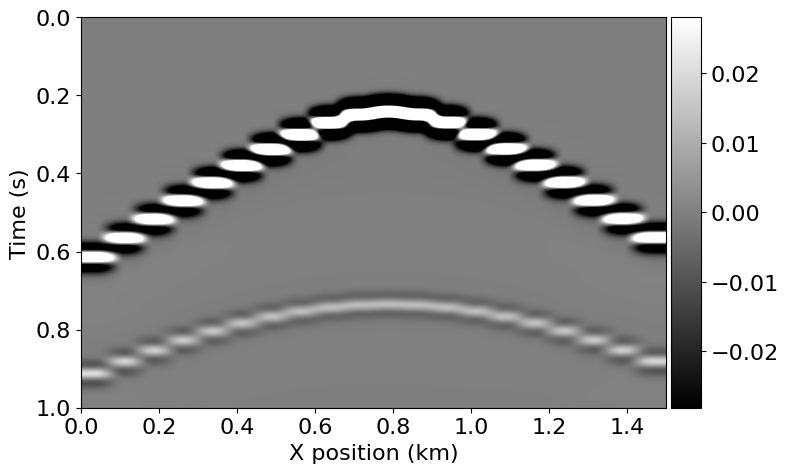

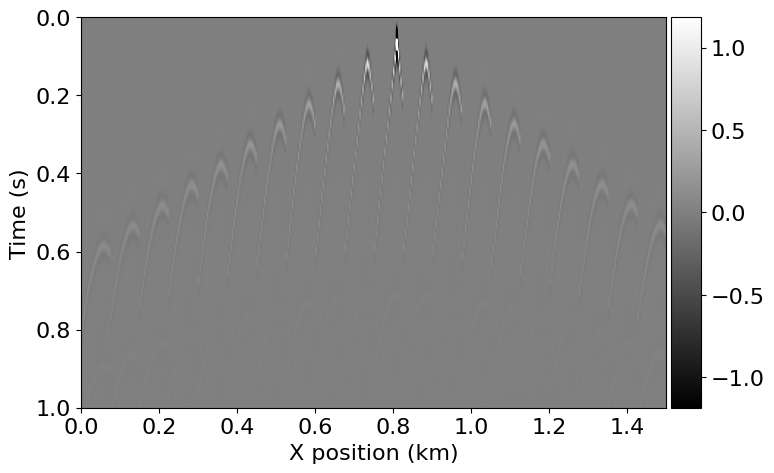

Operator `initdamp` ran in 0.02 s
Operator `Kernel` ran in 26.00 s


fd shot  0


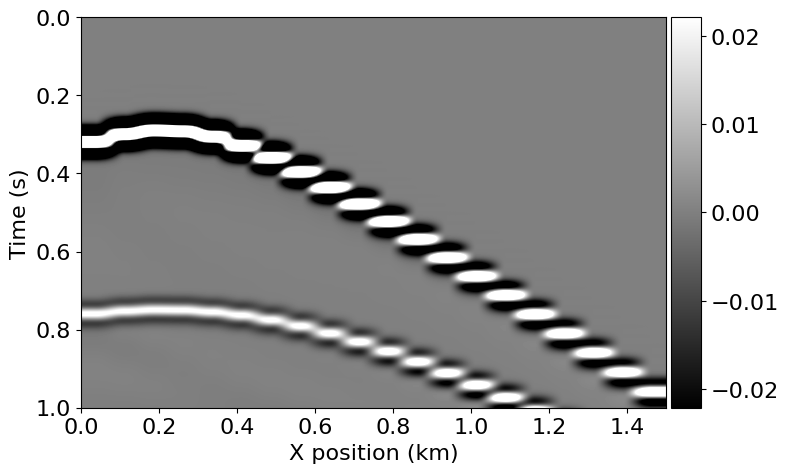

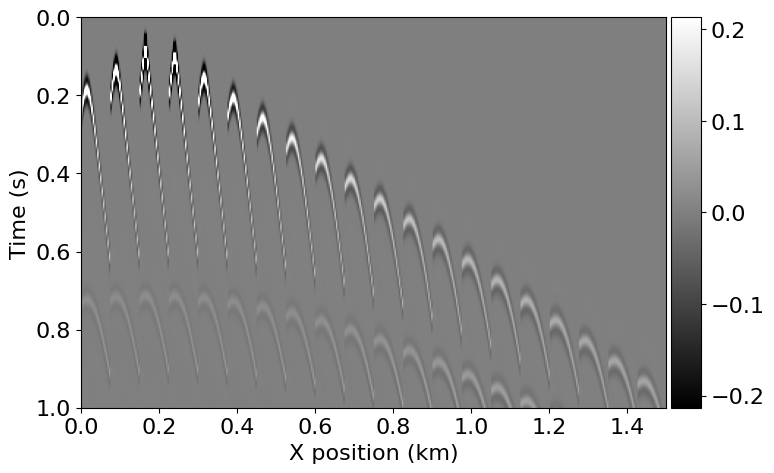

Operator `Kernel` ran in 25.61 s


fd shot  1


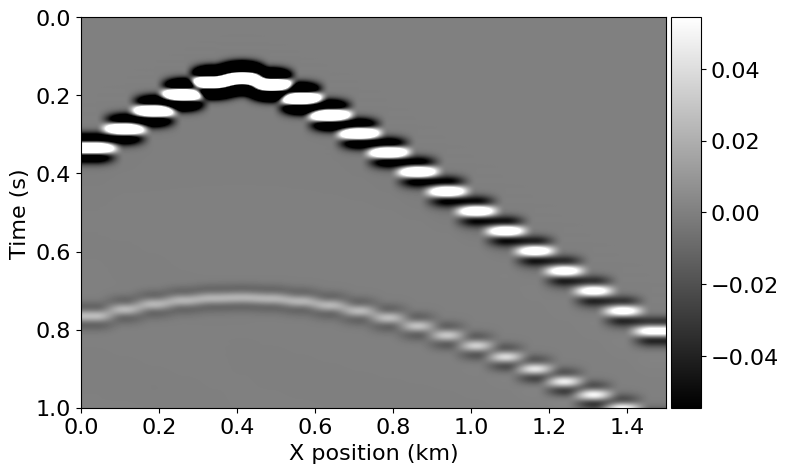

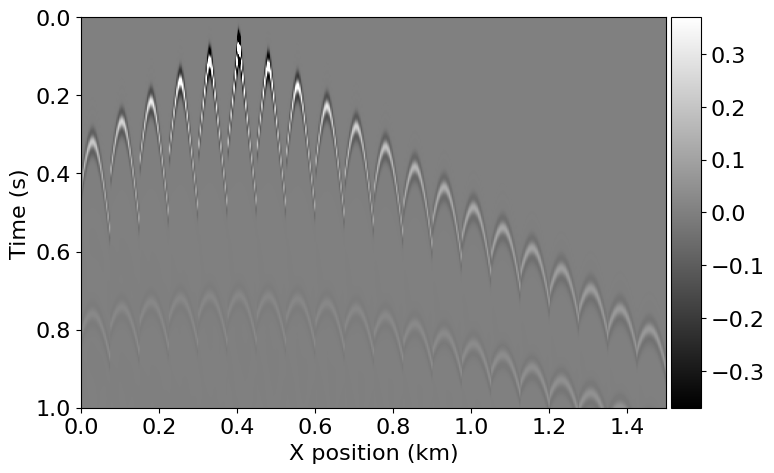

Operator `Kernel` ran in 25.94 s


fd shot  2


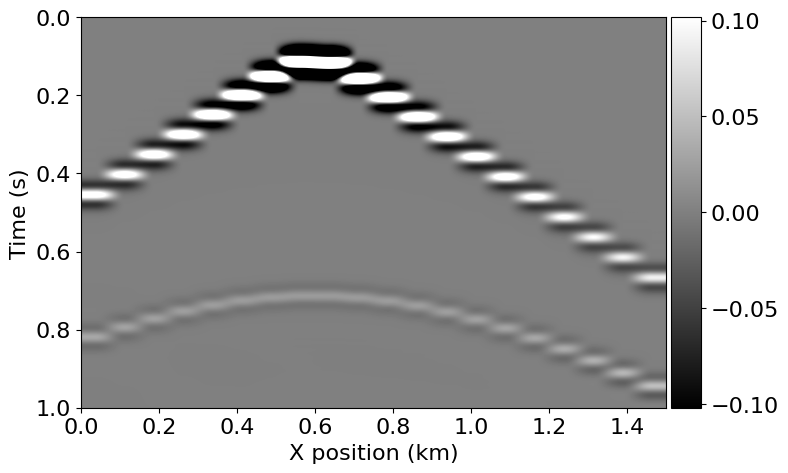

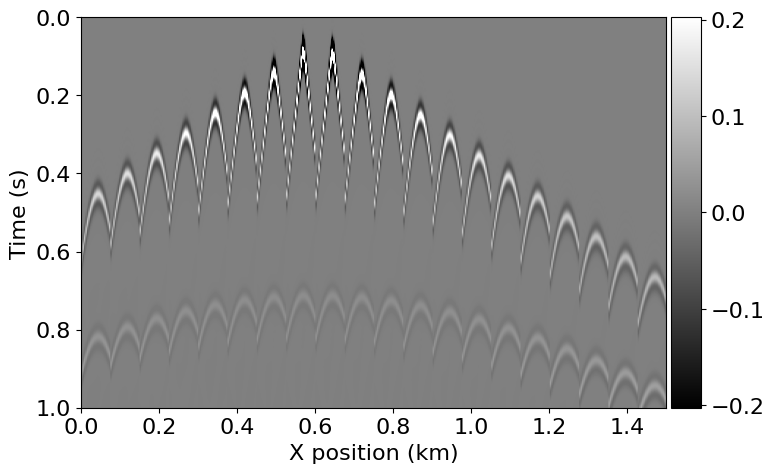

Operator `Kernel` ran in 25.14 s


fd shot  3


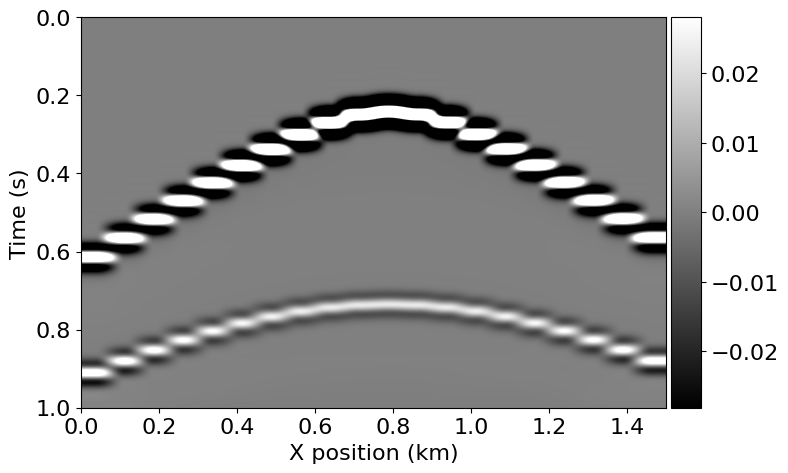

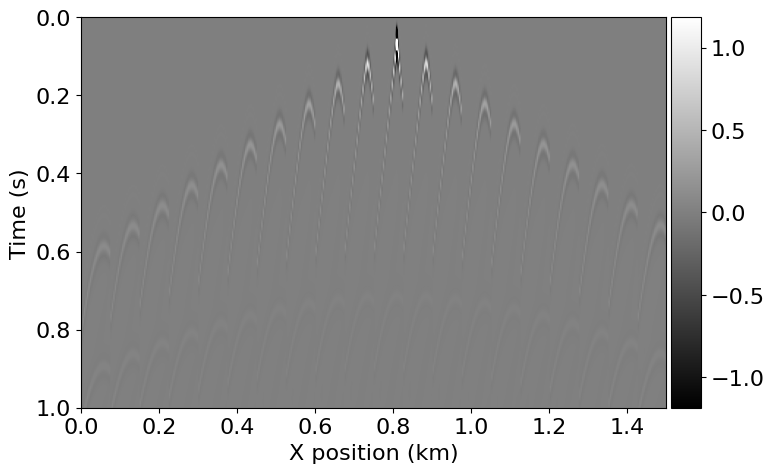

Operator `initdamp` ran in 0.02 s
Operator `Kernel` ran in 25.48 s


fd shot  0


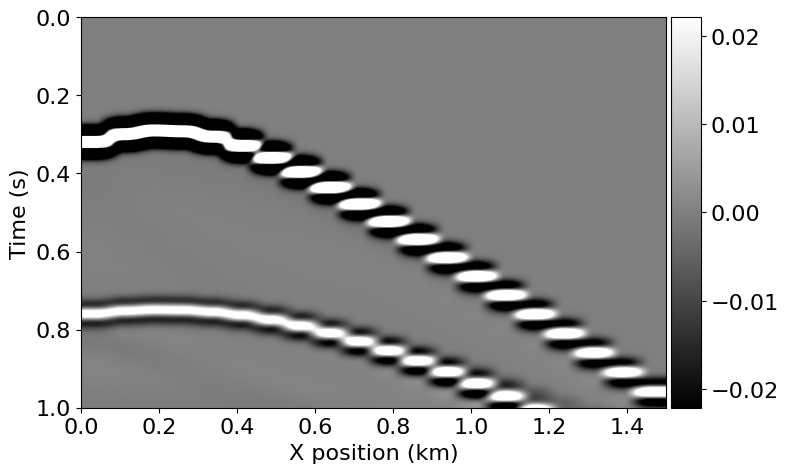

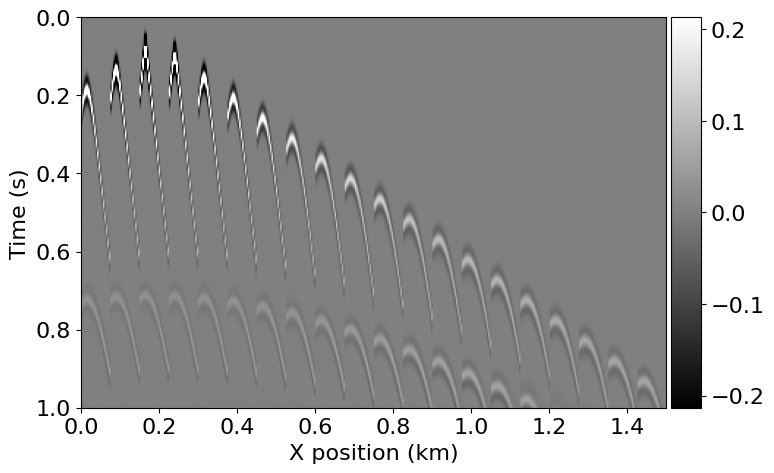

Operator `Kernel` ran in 25.54 s


fd shot  1


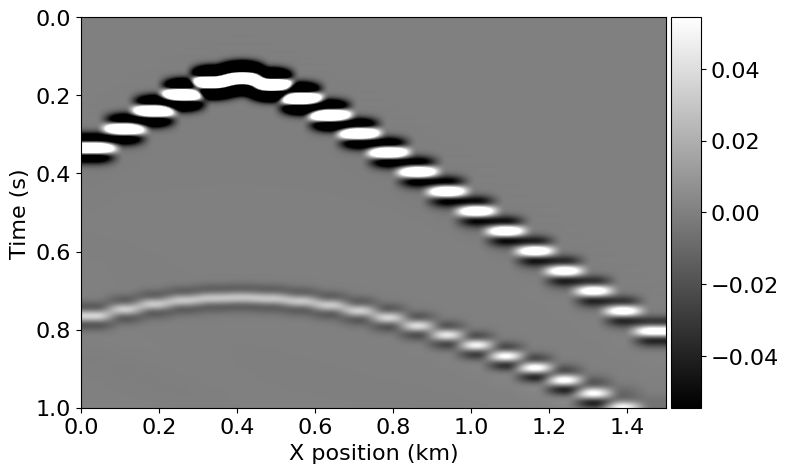

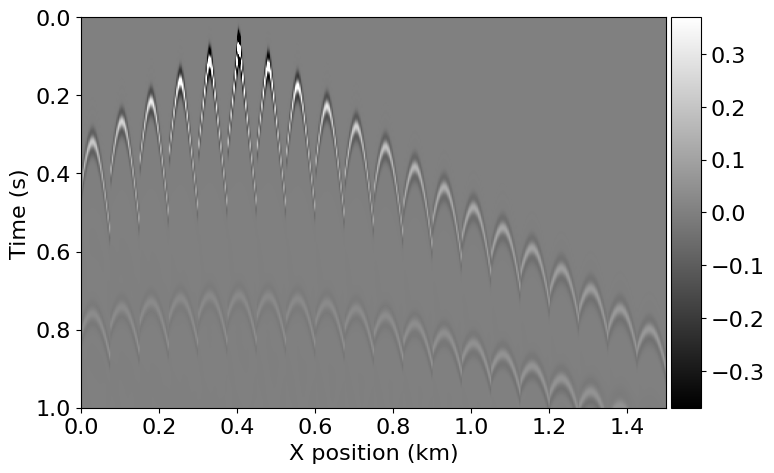

Operator `Kernel` ran in 25.61 s


fd shot  2


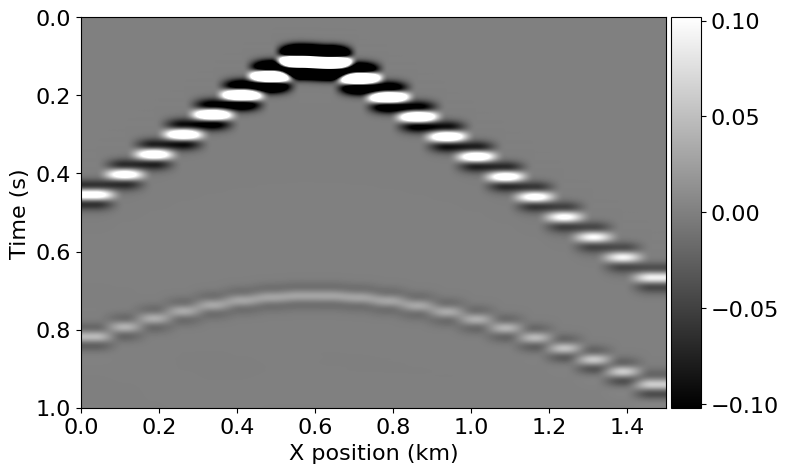

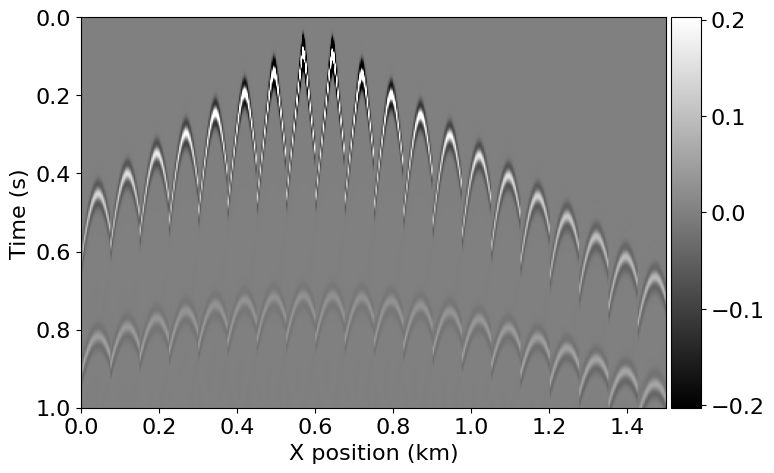

Operator `Kernel` ran in 25.71 s


fd shot  3


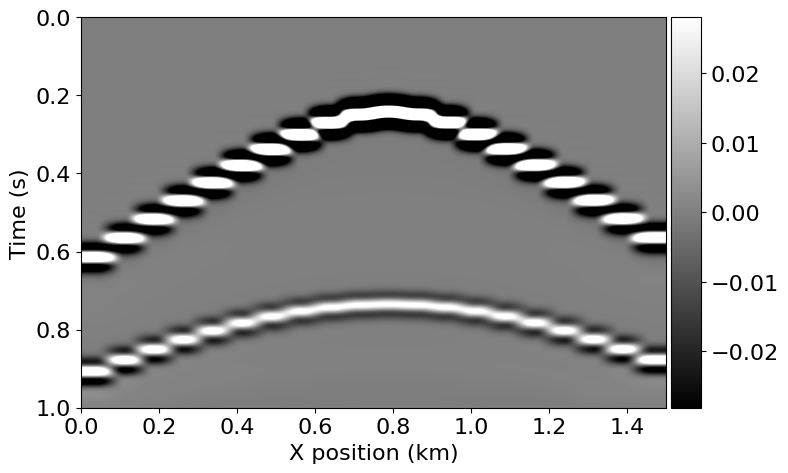

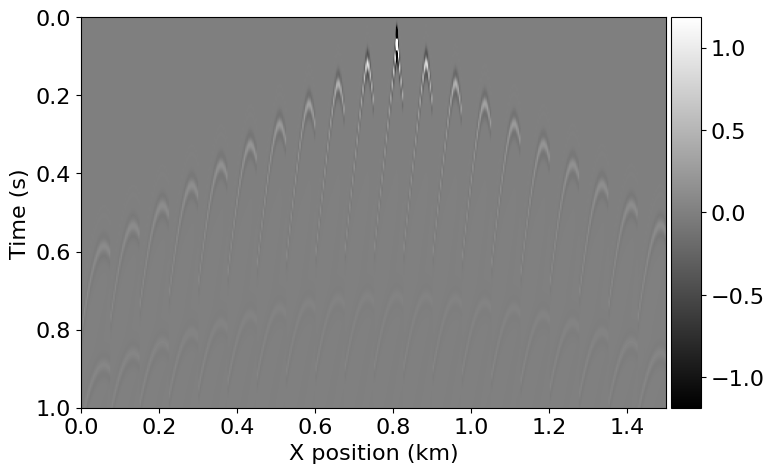

In [22]:
#NBVAL_IGNORE_OUTPUT
import numpy as np
%matplotlib inline
from examples.seismic import RickerSource
from devito import Operator
from examples.seismic import plot_shotrecord
import scipy.io as spio
from examples.seismic import Receiver
from devito import TimeFunction
from devito import Eq, solve
from examples.seismic import TimeAxis
from examples.seismic import Model, plot_velocity


def check_points_per_wavelength(min_vel, freq, dx, dt):
    if freq is not None:
        
        min_vel = min_vel*1000
        freq = freq*1000
        dt = dt/1000
        min_wavelength = min_vel / freq
        max_spacing = dx
        if min_wavelength / max_spacing <= 6:
            print("At least six grid cells per wavelength is "
                          "recommended, but at a frequency of {}, a "
                          "minimum velocity of {}, and a grid cell "
                          "spacing of {}, there are only {}."
                          .format(freq, min_vel, max_spacing,
                                  min_wavelength / max_spacing))
        if 1/2/dt < freq:
            print("The provided freq is greater than the "
                          "Nyquist frequency of the data.")


nv = 3
velocity_nv = [(1.5,2.0),(1.5,2.5),(1.5,3.0)]
ns = 4
src_ns = [(200,200),(400,400),(600,600),(800,800)]


for index_v in range(nv):
    
    # Define a physical size
    shape = (151, 101, 101)  # Number of grid point (nx, ny, nz)
    spacing = (10., 10., 10)  # Grid spacing in m. The domain size is now dx=1km, dy=1km, dz=1km
    origin = (0., 0., 0.)  # What is the location of the top left corner (x,y,z). This is necessary to define

    t0 = 0.  # Simulation starts a t=0
    tn = 1000.  # Simulation last 1 second (1000 ms) , 需要注意是否足够时间使得信号到达底部, total t=0~1000,1001
    # Time step from model grid spacing
    dt = 1.0 # ms dt < model.critical_dt
    print('CFL dt < model.critical_dt ', dt, '<', model.critical_dt)
    time_range = TimeAxis(start=t0, stop=tn, step=dt)
    
    # Define a velocity profile. The velocity is in km/s
    v = np.empty(shape, dtype=np.float32)
    v[:, :, :51] = velocity_nv[index_v][0]
    v[:, :, 51:] = velocity_nv[index_v][1]
    
    f0 = 0.015  # Source peak frequency is 15Hz (0.015 kHz)
    check_points_per_wavelength(np.min(v), f0, np.max(spacing), dt) # 注意是否会不满足波长条件，可能会有频散？
    
    # With the velocity and model size defined, we can create the seismic model that
    # encapsulates this properties. We also define the size of the absorbing layer as 10 grid points
    model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
                  space_order=8, nbl=50, bcs="damp")
    
    for index_s in range(ns):

        # Define the wavefield with the size of the model and the time dimension
        u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=8)

        # We can now write the PDE
        pde = model.m * u.dt2 - u.laplace + model.damp * u.dt

        # The PDE representation is as on paper
        # pde

        stencil = Eq(u.forward, solve(pde, u.forward))
        # stencil

        src = RickerSource(name='src', grid=model.grid, f0=f0,
                       npoint=1, time_range=time_range)

        # First, position source centrally in all dimensions, then set depth
        # src_2d.coordinates.data[:,0] = np.repeat(np.linspace(100, model_2d.domain_size[0], num=2), 2)
        # src_2d.coordinates.data[:,1] = np.tile(np.linspace(100, model_2d.domain_size[1], num=2), 2)
        src.coordinates.data[0,0] = src_ns[index_s][0]
        src.coordinates.data[0,1] = src_ns[index_s][1]
        src.coordinates.data[0,2] = 20.  # Depth is 20m

        # Create symbol for 400 receivers
        rec = Receiver(name='rec', grid=model.grid, npoint=400, time_range=time_range)

        # Prescribe even spacing for receivers along the x-axis
        rec.coordinates.data[:, 0] = np.repeat(np.linspace(20, model.domain_size[0], num=20), 20)
        rec.coordinates.data[:, 1] = np.tile(np.linspace(20, model.domain_size[1], num=20), 20)
        rec.coordinates.data[:, 2] = 20.  # Depth is 20m

        # Create interpolation expression for receivers
        rec_term = rec.interpolate(expr=u.forward)

        # Finally we define the source injection and receiver read function to generate the corresponding code
        src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)

        op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)

        op(time=time_range.num-1, dt=dt)

        print('fd velocity', index_v, ' shot',index_s)

        # reshape t x y
        temp = rec.data.reshape(1001,20,20)
        plot_shotrecord(temp[:,:,10], model, t0, tn)

        plot_shotrecord(rec.data, model, t0, tn)

        file_save_data = './data/'
        spio.savemat(file_save_data + 'data_v'+ str(index_v) + '_s' + str(index_s) + '.mat',{'rec_data':rec.data,})